In [2]:
import numpy as np
import pandas as pd
import sys
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, HTML, clear_output
import time

In [4]:
# os.chdir("..")
HOME = os.getcwd()
HOME

'/Users/danielcosta/Berkeley/207/Final_Project'

In [5]:
HOME = os.getcwd()
IMAGE_DATA_PATH = f"{HOME}/Data/Weather_Dataset"
IMAGE_TENSOR_PATH = f"{HOME}/Data/Image_Tensors"

def load_jpg_to_tensor(image_filepath):
    """
    Reads a JPG image and converts it to a TensorFlow tensor.

    Args:
        image_path (str): Path to the JPG image file, relative to IMAGE_DATA_PATH

    Returns:
        A TensorFlow tensor representing the image.
    """
    # Read the image file
    absolute_image_filepath = os.sep.join((IMAGE_DATA_PATH, image_filepath))
    image_string = tf.io.read_file(absolute_image_filepath)
    
    # Decode the JPG image to a tensor
    try:
        image_tensor = tf.image.decode_image(image_string, channels=3) 
    except tf.errors.InvalidArgumentError:
        print(f"Invalid image file: {absolute_image_filepath}")
        return None
    
    return image_tensor

def serialize_image_tensor(image_filepath):
    """
    Converts image to tensor, serializes tensor, and saves it to a binary file.

    Args:
        image_filenpath (str): Path to the JPG image file, relative to IMAGE_DATA_PATH
    """
    tensor = load_jpg_to_tensor(image_filepath)
    if tensor.ndim == 4:
        # get list of tensors from GIF
        tensors = [tensor for tensor in tensor]
    else:
        tensors = [tensor]

    for i, tensor in enumerate(tensors):
        
        serialized_tensor = tf.io.serialize_tensor(tensor)

        image_filepath_no_ext = image_filepath.split(".")[0]
        if len(tensors) > 1:
            image_filepath_no_ext = f"{image_filepath_no_ext}_{i+1}"

        serialized_tensor_filepath = os.sep.join((IMAGE_TENSOR_PATH, f"{image_filepath_no_ext}.bin"))

        with open(serialized_tensor_filepath, "wb") as f:
            f.write(serialized_tensor.numpy())

    return None

def deserialize_image_tensor(image_filepath):
    """
    Reads serialized tensor binary file associated with image,
    deserializes the tensor, and returns it.

    Args:
        image_filepath (str): Path to the JPG image file, relative to IMAGE_DATA_PATH

    Returns:
        tf.Tensor: Original Image Tensor
    """
    image_filepath_no_ext = image_filepath.split(".")[0]
    serialized_tensor_filepath = os.sep.join((IMAGE_TENSOR_PATH, f"{image_filepath_no_ext}.bin"))

    with open(serialized_tensor_filepath, "rb") as f:
        deserialized_tensor = tf.io.parse_tensor(f.read(), out_type=tf.uint8)
        
    return deserialized_tensor

In [6]:
def get_tensors():
    """
    Returns the shapes of all serialized image tensors in the dataset.
    """
    tensors = {}
    for dirpath, dirnames, filenames in os.walk(IMAGE_TENSOR_PATH):
        for dirname in dirnames:
            class_path = os.path.join(dirpath, dirname)
            for class_dirpath, class_dirnames, class_filenames in os.walk(class_path):
                for class_filename in class_filenames:
                    if class_filename.endswith('.bin'):
                        serialized_tensor_path = os.path.join(dirname, class_filename)
                        tensor = deserialize_image_tensor(serialized_tensor_path)
                        tensors[serialized_tensor_path.split(".")[0]] = tensor
    return tensors

tensor_dict = get_tensors()
labels = np.array([key.split('/')[0] for key in tensor_dict.keys()])
tensors = list(tensor_dict.values())


2025-02-26 09:05:51.073069: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-26 09:05:51.073257: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-02-26 09:05:51.073264: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-02-26 09:05:51.073443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-26 09:05:51.073458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
def create_feature_matrix(tensors):
    """
    Creates a feature matrix from the serialized image tensors.

    Args:
        tensors (dict): Dictionary of image tensors

    Returns:
        pd.DataFrame: Feature matrix
    """

    data = [[key.split("/")[-1], value, key.split("/")[0]] for key, value in tensors.items()]
    df = pd.DataFrame(data, columns=["Image ID", "Tensor", "Label"])
    
    return df
   

In [7]:
def get_shapes(tensors):
    """
    Returns the shapes of all serialized image tensors in the dataset.
    """
    return [tensor.shape for tensor in tensors]

tensor_shapes = get_shapes(tensors)

In [8]:
heights = [shape[0] for shape in tensor_shapes]
widths = [shape[1] for shape in tensor_shapes]
max_height = max(heights)
max_width = max(widths)

print("Max Height:", max_height)
print("Max Width:", max_width)

Max Height: 3174
Max Width: 4863


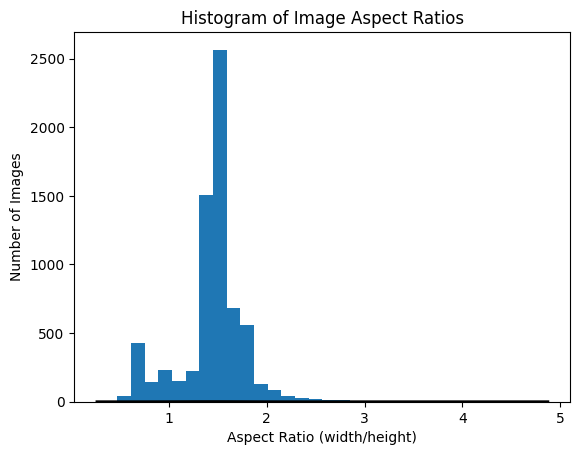

In [45]:
from scipy.stats import norm
aspect_ratios = [width/height for width, height in zip(widths, heights)]
sizes = [width*height for width, height in zip(widths, heights)]
plt.hist(aspect_ratios, bins=30)
mu, std = norm.fit(aspect_ratios)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


plt.title("Histogram of Image Aspect Ratios")
plt.xlabel("Aspect Ratio (width/height)")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
zip(widths, heights)

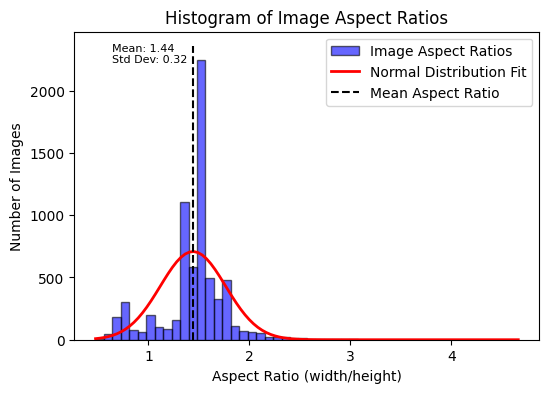

In [105]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate synthetic dataset
np.random.seed(42)
data = aspect_ratios  # Mean=50, Std Dev=10, Size=1000

# Compute histogram bins
bins = 50
counts, bin_edges = np.histogram(data, bins=bins)

# Compute mean and standard deviation
mu, sigma = np.mean(data), np.std(data)

# Create normal distribution curve
x = np.linspace(min(data), max(data), 100)
pdf = stats.norm.pdf(x, mu, sigma) * len(data) * np.diff(bin_edges)[0]  # Scale to match histogram counts

# Plot
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust height dynamically
ax.hist(data, bins=bins, alpha=0.6, color='b', edgecolor='black', label="Image Aspect Ratios", density=False)
ax.plot(x, pdf, 'r-', lw=2, label="Normal Distribution Fit")
ymin, ymax = ax.get_ylim()
ax.vlines(mu, ymin, ymax, color='k', linestyle='--', label="Mean Aspect Ratio")

# Labels and title
ax.set_xlabel("Aspect Ratio (width/height)")
ax.set_ylabel("Number of Images")
ax.set_title("Histogram of Image Aspect Ratios")
ax.text(0.08, 0.9, f"Mean: {mu:.2f}\nStd Dev: {sigma:.2f}", transform=ax.transAxes, fontsize=8)
ax.legend()

# Show plot
plt.show()


In [32]:
class_sizes = {}
for dirpath, dirnames, filenames in os.walk(IMAGE_DATA_PATH):
    for dirname in dirnames:
        class_path = os.path.join(dirpath, dirname)
        for class_dirpath, class_dirnames, class_filenames in os.walk(class_path):
            class_sizes[dirname] = len(class_filenames)
            

In [40]:

class_sizes = dict(sorted(class_sizes.items(), key=lambda item: item[1], reverse=True))
# Output: {'a': 5, 'b': 2, 'c': 1}


In [43]:
sum(class_sizes.values())

6604

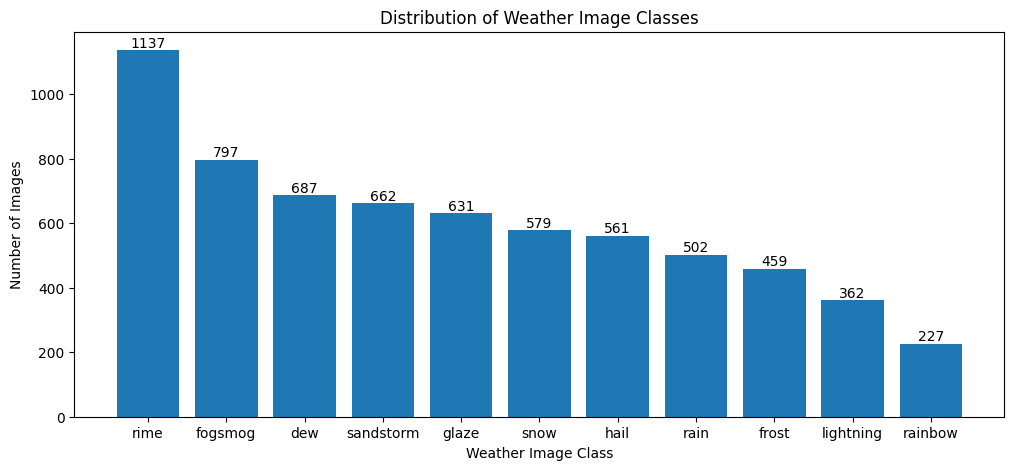

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
classes = list(class_sizes.keys())
n_images = list(class_sizes.values())
ax.bar(classes, n_images)
ax.set_xlabel("Weather Image Class")
ax.set_ylabel("Number of Images")
ax.set_title("Distribution of Weather Image Classes")
for i in range(len(classes)):
    ax.text(i, n_images[i], str(n_images[i]), ha='center', va='bottom')
plt.show()

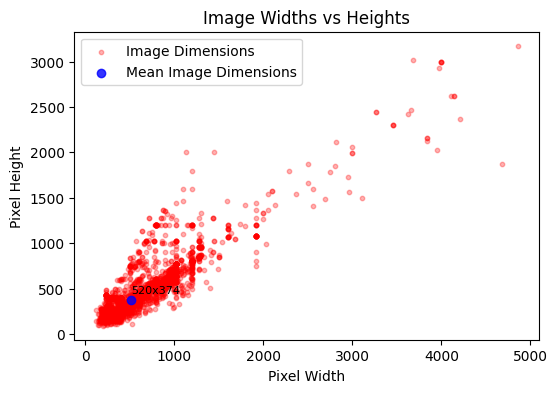

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate synthetic empirical data (Replace with your real dataset)
np.random.seed(42)
x = np.array(widths) # X values (e.g., feature 1)
y = np.array(heights) # Y values (e.g., feature 2)




# Scatter the actual data points
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(x, y, s=10, color="red", alpha=0.3, label="Image Dimensions")

# Optional: Customize the dot's appearance
plt.scatter([np.mean(widths)], [np.mean(heights)], marker='o',  color='blue', alpha=0.8, label="Mean Image Dimensions")

# Labels and title
plt.xlabel("Pixel Width")
plt.ylabel("Pixel Height")
plt.title("Image Widths vs Heights")
plt.text(np.mean(widths)+550, np.mean(heights)+50, "520x374", fontsize=8, verticalalignment='bottom', horizontalalignment='right')
plt.legend()
plt.show()


In [86]:
print(np.mean(widths))
print(np.mean(heights))
print(np.mean(aspect_ratios))
# 520 x 374

520.0494905385735
373.8285298398836
1.4407223029769323
1.7777777777777777


### Version 1: Pad everything to maximum

In [ ]:
v1_height, v1_width = max_height, max_width

It seems that if we pad to the maximum dimensions of our images, the tensors will be heavily padded. Let's try to find a happy medium shape to resize/pad.

### Version 2: Pad everything to chosen percentile, resize and pad for larger images

In [11]:
# pick a maximum height and width such that 95%+ of images are included
image_dims = [shape[:2].as_list() for shape in tensor_shapes]

In [12]:
def percent_fits(image_dims, max_height, max_width):
    """
    Returns the percentage of images that fit within the given dimensions.

    Args:
        image_dims (list): List of image dimensions.
        max_height (int): Maximum height.
        max_width (int): Maximum width.

    Returns:
        float: Percentage of images that fit within the given dimensions.
    """
    fits = [dim for dim in image_dims if dim[0] <= max_height and dim[1] <= max_width]
    return 100* len(fits) / len(image_dims)

def find_max_dims(image_dims, percentile):
    """
    Finds the maximum height and width such that at least `percentile` of images are included.

    Args:
        image_dims (list): List of image dimensions.
        percentile (float): Percentile to find.

    Returns:
        tuple: Maximum height and width.
    """
    print(f"Finding max dims for {percentile:.1f}% of images...")
    heights = [dim[0] for dim in image_dims]
    widths = [dim[1] for dim in image_dims]

    initial_height = int(np.percentile(heights, percentile))
    initial_width = int(np.percentile(widths, percentile))

    # do a BFS to find the minimum height and width that includes at least 95% of images

    visited = bfs(initial_height, initial_width, percentile)

    if len(visited) == 0:
        return initial_height, initial_width

    best_height, best_width = sorted(list(visited), key=lambda x: x[0] * x[1])[0]

    return best_height, best_width

def bfs(initial_height, initial_width, percentile, max_height=max_height, max_width=max_width):
    """
    Returns the minimum height and width such that at least the given percentile of images are included.

    Args:
        areas (list): List of image areas.
        aspect_ratios (list): List of image aspect ratios.
        initial_height (int): Initial height.
        initial_width (int): Initial width.
        percentile (float): Percentile to include.

    Returns:
        tuple: Minimum height and width.
    """
    queue = [(initial_height, initial_width)]
    visited = set()
    while queue:
        height, width = queue.pop(0)
        percent = percent_fits(image_dims, height, width)
        if percent >= percentile:
            return visited
        if (height, width) in visited:
            continue
        visited.add((height, width))
        queue.append((height + 1, width))
        queue.append((height, width + 1))


We can see that there is a steep rise in both dimensions that starts after the 97.5 percentile mark. Let's choose this size to either pad or resize each image.

Finding max dims for 80.0% of images...
Finding max dims for 80.5% of images...
Finding max dims for 81.0% of images...
Finding max dims for 81.5% of images...
Finding max dims for 82.0% of images...
Finding max dims for 82.5% of images...
Finding max dims for 83.0% of images...
Finding max dims for 83.5% of images...
Finding max dims for 84.0% of images...
Finding max dims for 84.5% of images...
Finding max dims for 85.0% of images...
Finding max dims for 85.5% of images...
Finding max dims for 86.0% of images...
Finding max dims for 86.5% of images...
Finding max dims for 87.0% of images...
Finding max dims for 87.5% of images...
Finding max dims for 88.0% of images...
Finding max dims for 88.5% of images...
Finding max dims for 89.0% of images...
Finding max dims for 89.5% of images...
Finding max dims for 90.0% of images...
Finding max dims for 90.5% of images...
Finding max dims for 91.0% of images...
Finding max dims for 91.5% of images...
Finding max dims for 92.0% of images...


Text(0.5, 1.0, 'Height and Width of Smallest Box that Fits X% of Images')

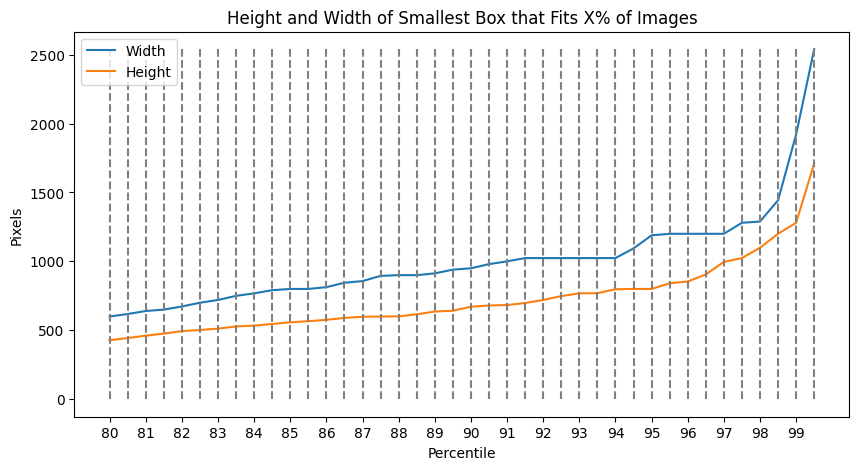

In [13]:
percentiles = np.arange(80, 100, 0.5)
heights, widths = zip(*[find_max_dims(image_dims, percentile=percentile) for percentile in percentiles])

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
plt.plot(percentiles, widths, label="Width")
plt.plot(percentiles, heights, label="Height")
plt.vlines(percentiles, ymin=0, ymax = max(max(heights),max(widths)), colors="gray", linestyles="dashed")
plt.xlabel("Percentile")
plt.ylabel("Pixels")
plt.legend()
plt.xticks(np.arange(80, 100))
plt.title("Height and Width of Smallest Box that Fits X% of Images")


It looks like after the 98th percentile, there is a precipitous increase in pixels needed to accommodate images. Let's choose the 98th percentile values for this shape.

In [23]:
# First, identify the 98th percentile height/width
percentile_index = np.where(percentiles == 98)[0][0]
v2_height, v2_width = heights[percentile_index], widths[percentile_index]
print(f"98th Percentile Height: {v2_height}")
print(f"98th Percentile Width: {v2_width}")

98th Percentile Height: 1099
98th Percentile Width: 1289


### Version 3: Find a shape that minimizes the percentage of padding needed to preserve aspect ratios

In [20]:
from datetime import datetime, timedelta
def progress(start_time, i, n, output_display):   
    elapsed_time = datetime.now() - start_time
    estimated_total_time = elapsed_time / (i + 1) * n
    remaining_time = estimated_total_time - elapsed_time
    progress_str = f"""Processing {i+1}/{n}
    {100*(i+1)/n:.2f}% done
    Started at: {start_time}
    Elapsed time: {elapsed_time}
    Estimated remaining time: {remaining_time}
    Estimated total time: {estimated_total_time}
    ETA: {start_time + estimated_total_time}
    Average time per image: {elapsed_time / (i + 1)}
    """
    clear_output(wait=True)
    output_display.update(HTML(f"<pre>{progress_str}</pre>")) 

def resize_preserve_aspect_ratio(height, width, img_height, img_width):
    height_shrinkage_factor = img_height/height
    width_shrinkage_factor = img_width/width
    shrinkage_factor = max(height_shrinkage_factor, width_shrinkage_factor)
    if shrinkage_factor <= 1:
        target_shape = (height, width)
    else:
        target_shape = (int(img_height/shrinkage_factor), int(img_width/shrinkage_factor))
    
    return target_shape
    
image_areas = [dim[0] * dim[1] for dim in image_dims]

def padding_loss(height, width, image_dims):
    resized_image_dims = [resize_preserve_aspect_ratio(height, width, dim[0], dim[1])
                          for dim in image_dims]
    resized_image_areas = [dim[0] * dim[1] for dim in resized_image_dims]

    total_image_areas_with_padding = height * width * len(image_dims)

    return total_image_areas_with_padding - sum(resized_image_areas)

def find_optimal_shape(image_dims, start_time, output_display):
    # Given EDA result from version 2, let's remove the extremes of the distribution for grid search
    width_range = np.arange(np.percentile(widths, 2), np.percentile(widths, 98), 1)
    height_range = np.arange(np.percentile(heights, 2), np.percentile(heights, 98), 1)
    n = len(width_range) * len(height_range)
    best_height, best_width = None, None
    best_loss = float("inf")
    i = 0
    for height in height_range:
        for width in width_range:
            i += 1
            loss = padding_loss(height, width, image_dims)
            if i % 1000 == 0:
                progress(start_time, i, n, output_display)
            if loss < best_loss:
                best_loss = loss
                best_height = height
                best_width = width
    return best_height, best_width
    


In [ ]:
start_time = datetime.now()
output_display = display(HTML(""), display_id=True)
        
best_height, best_width = find_optimal_shape(image_dims, start_time, output_display)

In [24]:
print(best_height, best_width)

1363.48 2036.04


In [ ]:
#v3_height, v3_width = best_height, best_width

def resize_or_pad(tensor, target_height, target_width):
    """
    Resizes or pads an image tensor to the target height and width.

    Args:
        tensor (tf.Tensor): Image tensor.
        target_height (int): Target height.
        target_width (int): Target width.

    Returns:
        tf.Tensor: Resized or padded image tensor.
    """
    return tf.image.resize_with_crop_or_pad(tensor, target_height=target_height, target_width=target_width)
v3_height, v3_width = (400, 600)
v3_tensors = np.array([tf.image.resize_with_crop_or_pad(tensor, target_height=v3_height, target_width=v3_width) for tensor in tensors])

In [ ]:
# Approach 1: Max Pad
# Approach 2: Happy Medium
# Approach 3: Minimize Padding

# Interpolation: Bicubic, NN, Bilinear
# Padding: Constant, Reflect, Symmetric

## Steps
- Data Ingestion into train and test sets
- EDA
    - Class balancing/augmentation
- Preprocessing (features and labels)
- Split into validation sets
- Shuffle (stratify)
- Modeling
    - Baseline
    - More Complex
- Hyperparameter Tuning
- Evaluation
    - Confusion Matrix

